# Capacity Factor
---

In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.simplefilter("ignore")

In [2]:
import analyze
from plot.analyze_pg import AnalyzePG
from westernintnet.westernintnet import win_data
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()

Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Done loading


In [3]:
def get_plant_id(zone, resource):
    plant_id = []
    if zone == 'Western':
        try:
            plant_id = win_data.genbus.groupby('type').get_group(resource).index.values.tolist()
        except KeyError:
            pass
    elif zone == 'California':
        CA = ['Bay Area', 'Central California', 'Northern California',
              'Southeast California', 'Southwest California']
        for load_zone in CA:
            try:
                plant_id += win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                    (load_zone, resource)).index.values.tolist()
            except KeyError:
                pass
    else:
        try:
            plant_id = win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                (zone, resource)).index.values.tolist()
        except KeyError:
            pass
    
    return plant_id

In [4]:
def prepare_data(scenario):
    #renewable profiles
    win_data.read_solar_data('sam')
    win_data.read_wind_data()
    
    if scenario is "2016":
        # generation
        PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG.pkl')
        # demand
        win_data.read_demand_data('v3')
        # renewable multipliers
        multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
    elif scenario is "ca2020" or scenario is "ca2020_congestion":
        # generation
        if scenario is "ca2020":
            PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2020.pkl')
        else:
            PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2020_CALineCapacityX2.pkl')
        # demand
        win_data.read_demand_data('cal2020')
        # renewable multipliers
        factor = [1.52, 1.48]
        multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
        for i, resource in enumerate(['solar', 'wind']):
            plant_id = get_plant_id('California', resource)
            multiplier.loc[plant_id] = factor[i]
    elif scenario is "ca2030" or scenario is "ca2030_congestion":
        # generation
        if scenario is "ca2030":
            PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2030.pkl')
        else:
            PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2030_CALineCapacityX2.pkl')
        # demand
        win_data.read_demand_data('cal2030')
        # renewable multipliers
        factor = [2.3, 2.3]
        multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
        for i, resource in enumerate(['solar', 'wind']):
            plant_id = get_plant_id('Western', resource)
            multiplier.loc[plant_id] = factor[i]
    elif scenario is "west2020":
        # generation
        PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2020_WestTarget.pkl')
        # demand
        win_data.read_demand_data('cal2020')
        # renewable multipliers
        factor = [2.25, 2.25]
        multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
        for i, resource in enumerate(['solar', 'wind']):
            plant_id = get_plant_id('Western', resource)
            multiplier.loc[plant_id] = factor[i]
    elif scenario is "west2030":
        # generation
        PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2030_WestTarget.pkl')
        # demand
        win_data.read_demand_data('cal2030')
        # renewable multipliers
        factor = [5, 5]
        multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
        for i, resource in enumerate(['solar', 'wind']):
            plant_id = get_plant_id('Western', resource)
            multiplier.loc[plant_id] = factor[i]
    
    return (PG, win_data, multiplier)

In [5]:
def do_yield_analysis(data, time, zones):
    resources = ['solar', 'wind']
    cf = AnalyzePG(data, time, zones, resources, 'yield', normalize=False)
    cf.get_plot(save=False)
    data_cf = cf.get_data()
    print('----------------------------------------')
    for z in zones:
        print("Capacity factor in %s: " % z)
        for r in resources:
            if data_cf[z][r] is not None:
                print("%s: %.3f (pre-simulation) / %.3f (post-simulation)" % (r, data_cf[z][r][0], data_cf[z][r][1]))
        print('----------------------------------------')

## Scenario

In [6]:
scenario = "west2020"

## Annual

Load solar data
Load wind data
Load demand data
No solar plants in Montana
No solar plants in Wyoming


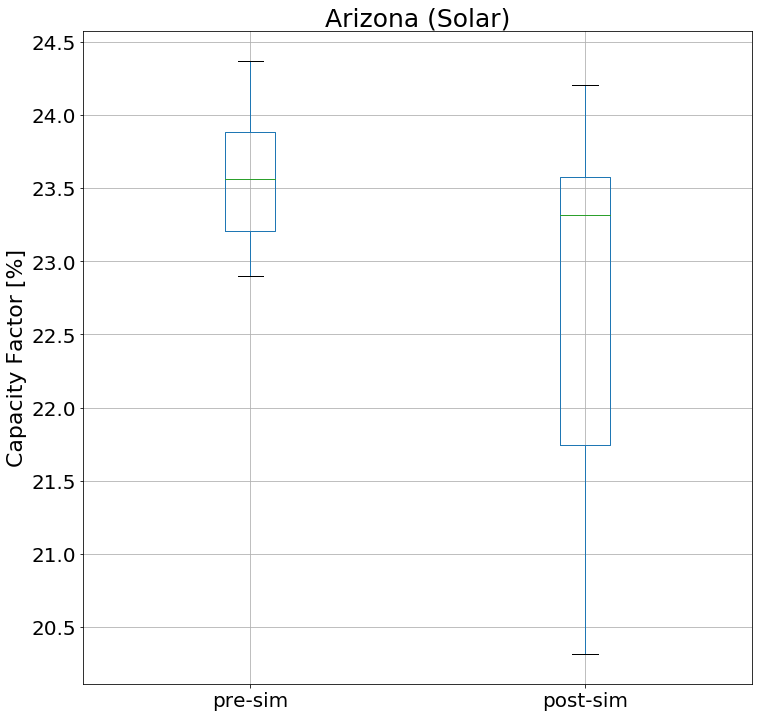

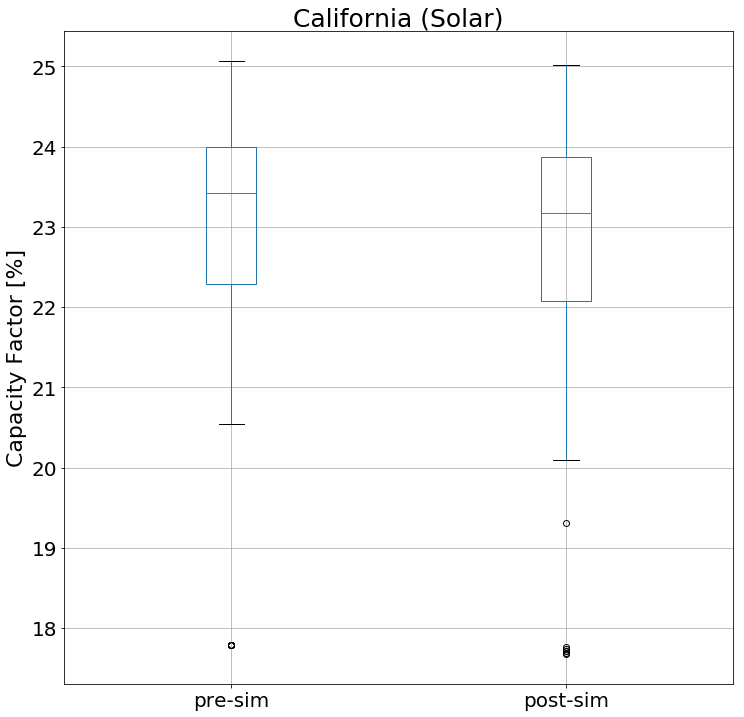

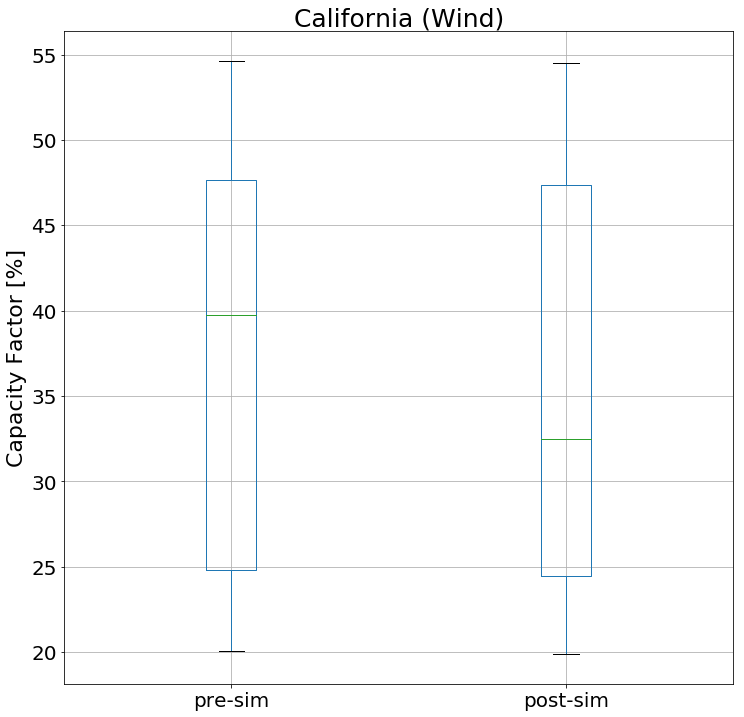

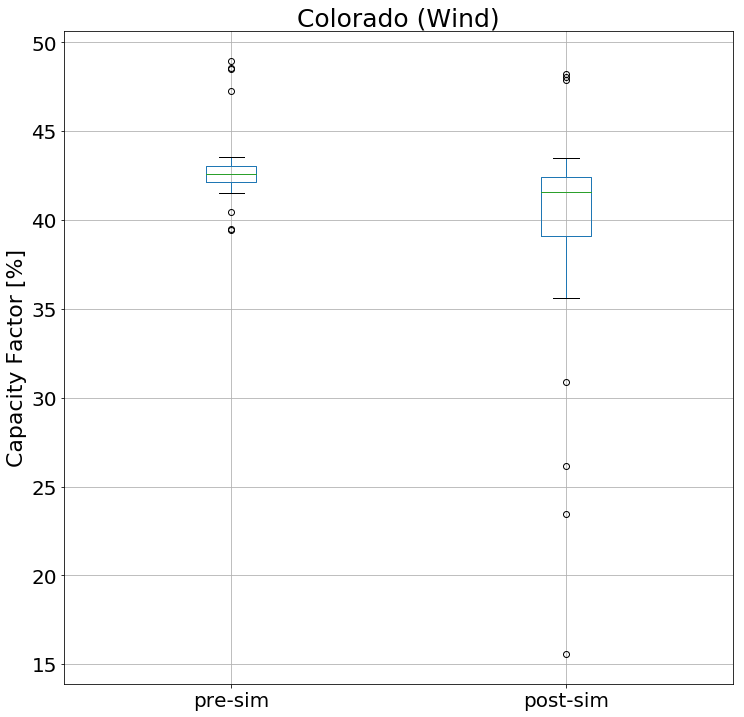

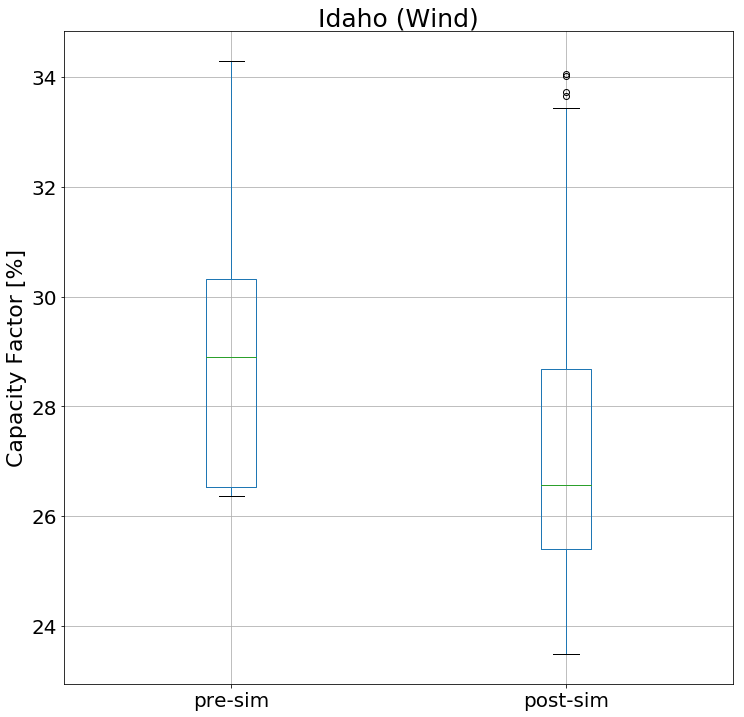

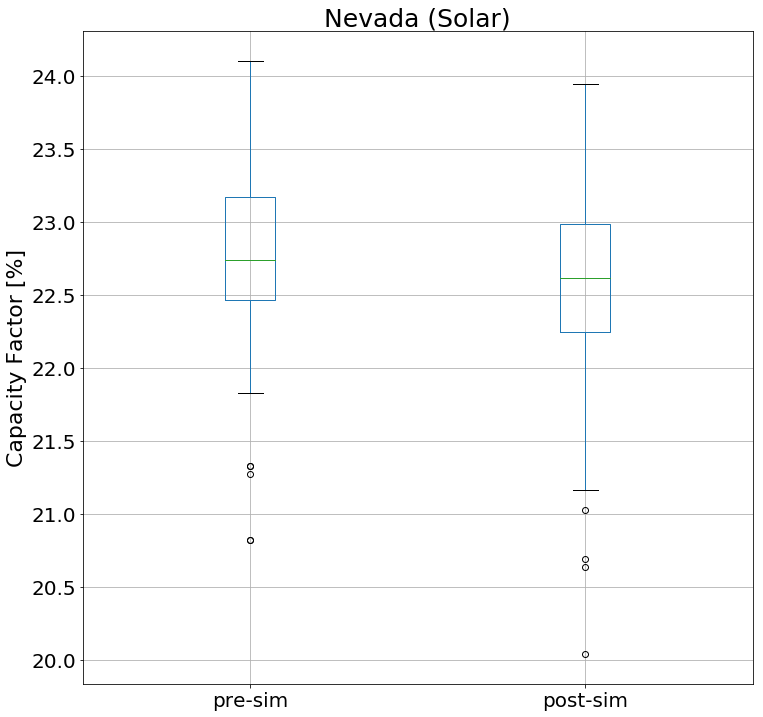

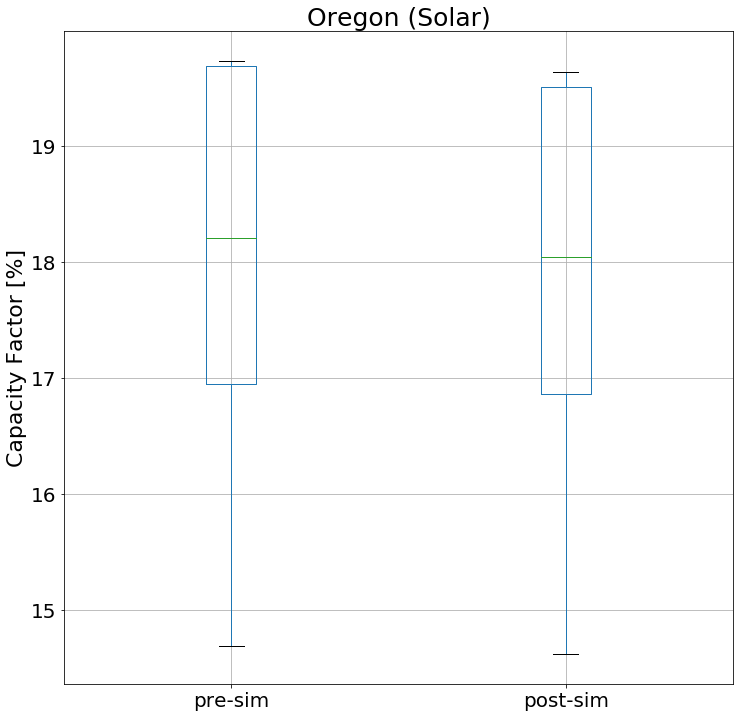

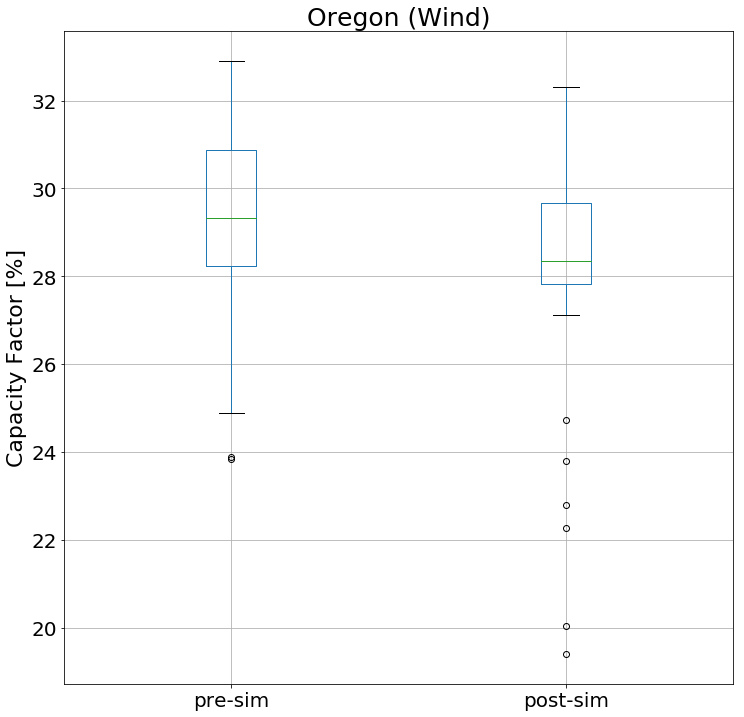

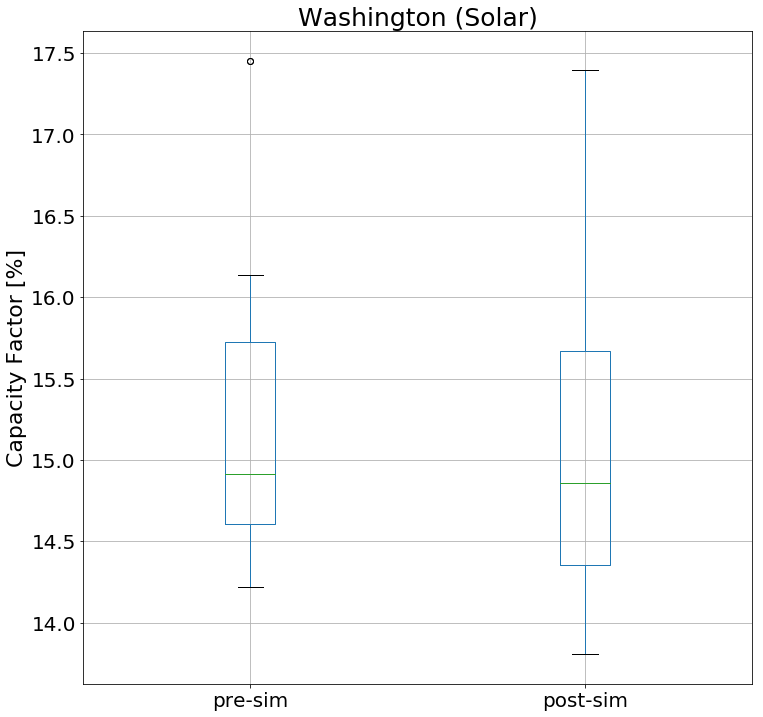

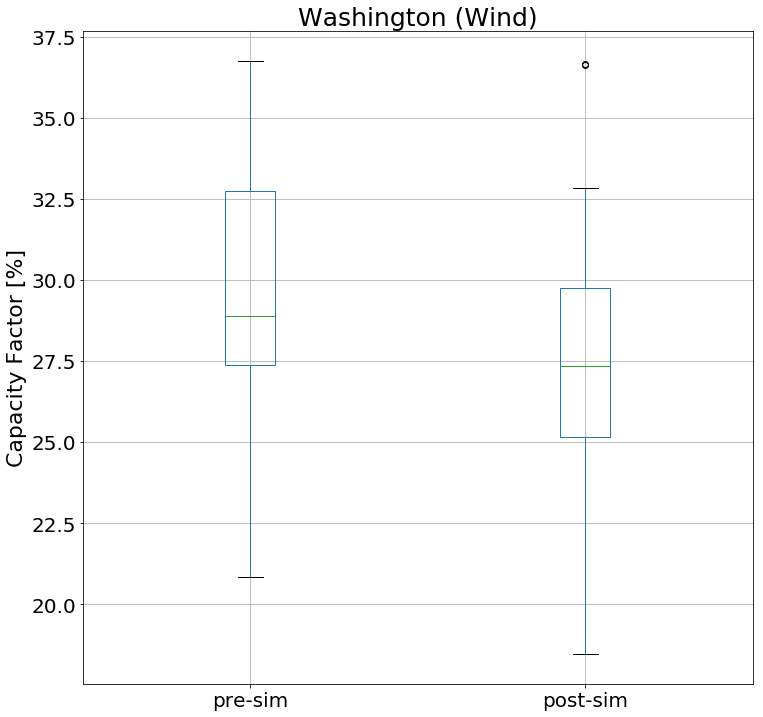

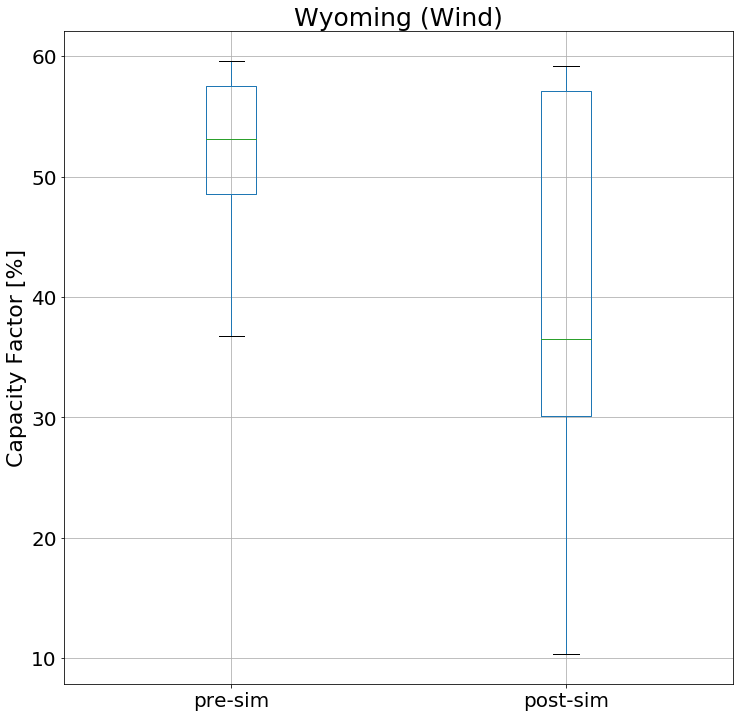

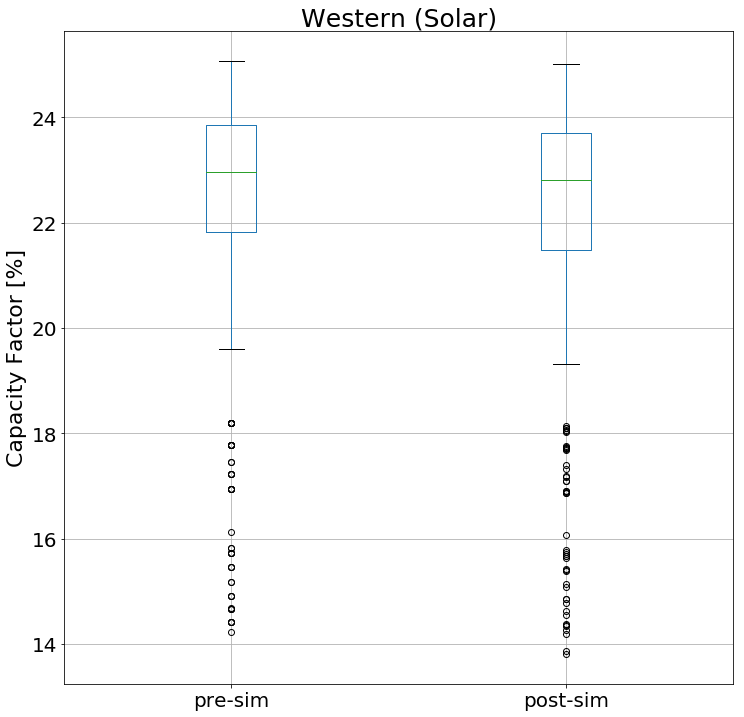

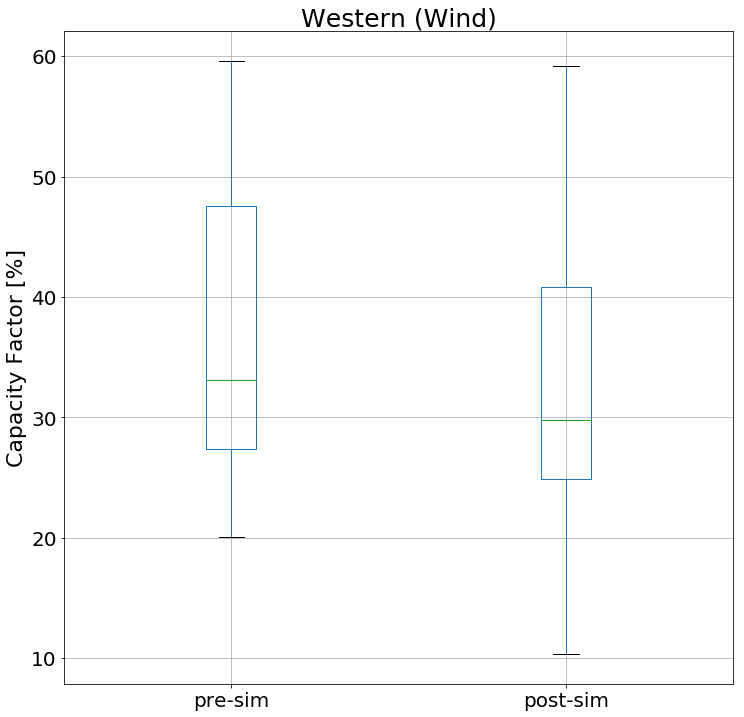

----------------------------------------
Capacity factor in Arizona: 
solar: 0.236 (pre-simulation) / 0.228 (post-simulation)
wind: 0.315 (pre-simulation) / 0.313 (post-simulation)
----------------------------------------
Capacity factor in California: 
solar: 0.231 (pre-simulation) / 0.229 (post-simulation)
wind: 0.371 (pre-simulation) / 0.349 (post-simulation)
----------------------------------------
Capacity factor in Colorado: 
solar: 0.229 (pre-simulation) / 0.228 (post-simulation)
wind: 0.433 (pre-simulation) / 0.388 (post-simulation)
----------------------------------------
Capacity factor in Idaho: 
solar: 0.180 (pre-simulation) / 0.179 (post-simulation)
wind: 0.291 (pre-simulation) / 0.277 (post-simulation)
----------------------------------------
Capacity factor in Montana: 
wind: 0.391 (pre-simulation) / 0.344 (post-simulation)
----------------------------------------
Capacity factor in Nevada: 
solar: 0.227 (pre-simulation) / 0.225 (post-simulation)
wind: 0.403 (pre-simulat

In [7]:
time = ('2016-01-01-00', '2016-12-31-23', 'utc', 'H')
data = prepare_data(scenario)
zones = ['Arizona', 'California', 'Colorado', 'Idaho', 'Montana', 'Nevada',
         'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming', 'Western']
do_yield_analysis(data, time, zones)